In [34]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date


from urllib.parse import urlencode
import urllib.request
import json
import requests

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patheffects import withStroke
from scipy.stats import pearsonr

%matplotlib inline
plt.rcParams["font.family"] = "Verdana"

# Load and clean the data

### DOB Permit Issuance - [Source](https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a/about_data)

Data provided by The Department of Buildings (DOB). 

The dataset is updated daily with new records. 
Given this, the following code will be written so that it is sensitive to when the code is run, so **it will process the most up to date data each time**.

*To note: Each row/record in this dataset represents the life cycle of one permit for one work type. Several permits maybe associated with one job #.*

The exercise asked for an analysis on Active Major Construction permits, which means we need to filter for:
1) Active (We will define this as Permits that have been Issued/Re-issued and Expiration has not passed)
2) Major Construction permits (Job Type is of type NB or A1)

In [2]:
today = date.today()
print("Today's date is:", today)

Today's date is: 2024-07-31


In [3]:
# Getting a quick look at the columns, and make it more human readable
columns_json_url = 'https://data.cityofnewyork.us/api/views/ipu4-2q9a.json'
response = requests.get(columns_json_url)
data = response.json()
column_mapping = {column['fieldName']:column['name'].lower().replace(" ","_") for column in data['columns']}
dob_permits_API = "https://data.cityofnewyork.us/resource/ipu4-2q9a.csv?"
dob_permits = pd.read_csv(dob_permits_API)
dob_permits_columns = dob_permits.dtypes.reset_index()
dob_permits_columns.columns = ['field_name', 'data_type']
dob_permits_columns['column_name'] = dob_permits_columns['field_name'].map(column_mapping)

In [4]:
dob_permits_columns

field_name data_type  \
0                            borough    object   
1                              bin__     int64   
2                            house__    object   
3                        street_name    object   
4                              job__     int64   
5                         job_doc___     int64   
6                           job_type    object   
7                          self_cert    object   
8                              block     int64   
9                                lot     int64   
10                   community_board     int64   
11                          zip_code     int64   
12                         bldg_type   float64   
13                       residential    object   
14                special_district_1    object   
15                special_district_2   float64   
16                         work_type    object   
17                     permit_status    object   
18                     filing_status    object   
19                       permit_type    object   
20                 permit_sequence__     int64   
21                    permit_subtype    object   
22                           oil_gas    object   
23                         site_fill    object   
24                       filing_date    object   
25                     issuance_date    object   
26                   expiration_date    object   
27                    job_start_date    object   
28            permittee_s_first_name    object   
29             permittee_s_last_name    object   
30         permittee_s_business_name    object   
31               permittee_s_phone__   float64   
32          permittee_s_license_type    object   
33             permittee_s_license__   float64   
34             act_as_superintendent    object   
35           permittee_s_other_title    object   
36                       hic_license   float64   
37      site_safety_mgr_s_first_name    object   
38       site_safety_mgr_s_last_name    object   
39     site_safety_mgr_business_name    object   
40  superintendent_first___last_name    object   
41      superintendent_business_name    object   
42             owner_s_business_type    object   
43                        non_profit    object   
44             owner_s_business_name    object   
45                owner_s_first_name    object   
46                 owner_s_last_name    object   
47                   owner_s_house__    object   
48         owner_s_house_street_name    object   
49                              city    object   
50                             state    object   
51                  owner_s_zip_code   float64   
52                   owner_s_phone__   float64   
53                        dobrundate    object   
54                      permit_si_no     int64   
55                      gis_latitude   float64   
56                     gis_longitude   float64   
57              gis_council_district   float64   
58                  gis_census_tract   float64   
59                      gis_nta_name    object   

                         column_name  
0                            borough  
1                              bin_#  
2                            house_#  
3                        street_name  
4                              job_#  
5                         job_doc._#  
6                           job_type  
7                          self_cert  
8                              block  
9                                lot  
10                   community_board  
11                          zip_code  
12                         bldg_type  
13                       residential  
14                special_district_1  
15                special_district_2  
16                         work_type  
17                     permit_status  
18                     filing_status  
19                       permit_type  
20                 permit_sequence_#  
21                    permit_subtype  
22                           oil_gas  
23                         site_fill  


In [5]:
# Pulling all New Building or Major Alteration A1 permits
## As all date fields are just text, we cannot filter using those field until we've parsed them
major_construction_permits_query = {'$select':'*', 
                     '$where': '(job_type="A1" OR job_type="NB") AND (permit_status="ISSUED" OR permit_status="RE-ISSUED")', # Filter for New Building or Major Alteration A1
                 '$limit':5000000}

df_permits = pd.read_csv(dob_permits_API + urlencode(major_construction_permits_query),
                         parse_dates = ['filing_date', 'issuance_date', 'expiration_date', 'job_start_date', 'dobrundate'])

display(df_permits)

borough    bin__ house__        street_name      job__  job_doc___  \
0       BROOKLYN  3006577     101    DOUGLASS STREET  321004603           1   
1       BROOKLYN  3171950    1272       EAST 10TH ST  321980335           1   
2          BRONX  2075402    3421  COUNTRY CLUB ROAD  220516118           1   
3         QUEENS  4623172     117   BEACH 215 STREET  421538731           1   
4       BROOKLYN  3048075     514    HERKIMER STREET  321598080           1   
...          ...      ...     ...                ...        ...         ...   
986837  BROOKLYN  3428578     120     LIBERTY AVENUE  321596386           1   
986838  BROOKLYN  3428673    7608         4TH AVENUE  321981851           1   
986839     BRONX  2128396    1358           ODELL ST  220152313           1   
986840     BRONX  2128396    1358           ODELL ST  220152313           1   
986841     BRONX  2128396    1358           ODELL ST  220152313           1   

       job_type self_cert    block    lot  ... state  owner_s_zip_code  \
0            NB         N    409.0   48.0  ...   NaN               NaN   
1            A1         N   6545.0   36.0  ...   NaN               NaN   
2            A1         N   5409.0  424.0  ...   NaN               NaN   
3            NB         N  16350.0  400.0  ...    NY           11697.0   
4            NB         N   1705.0   39.0  ...   NaN               NaN   
...         ...       ...      ...    ...  ...   ...               ...   
986837       NB         N     3693     22  ...   NaN               NaN   
986838       NB         N     5950     44  ...   NaN               NaN   
986839       NB         N     3934     37  ...   NaN               NaN   
986840       NB         N     3934     37  ...   NaN               NaN   
986841       NB         N     3934     37  ...   NaN               NaN   

        owner_s_phone__ dobrundate permit_si_no gis_latitude gis_longitude  \
0            7187079550 2022-05-11      3905856    40.683034    -73.991282   
1            9292949460 2022-05-11      3905857    40.618282    -73.964974   
2            9145303057 2022-05-11      3905860    40.839666    -73.815547   
3            7189452300 2020-06-18      3765467    40.554860    -73.923824   
4            7185004686 2022-05-11      3905861    40.678919    -73.936482   
...                 ...        ...          ...          ...           ...   
986837     2125668805.0 2024-07-31      3977373    40.672988    -73.905982   
986838     7183962700.0 2024-07-31      3979377    40.629961    -74.025431   
986839     3473456838.0 2024-07-31      3979407    40.835014    -73.853975   
986840     3473456838.0 2024-07-31      3979408    40.835014    -73.853975   
986841     3473456838.0 2024-07-31      3979409    40.835014    -73.853975   

       gis_council_district gis_census_tract  \
0                      33.0             69.0   
1                      44.0            454.0   
2                      13.0          27402.0   
3                      32.0          91601.0   
4                      36.0            271.0   
...                     ...              ...   
986837                 37.0            908.0   
986838                 43.0             64.0   
986839                 18.0            222.0   
986840                 18.0            222.0   
986841                 18.0            222.0   

                                             gis_nta_name  
0        DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill  
1                                     Ocean Parkway South  
2                     Pelham Bay-Country Club-City Island  
3       Breezy Point-Belle Harbor-Rockaway Park-Broad ...  
4                                     Crown Heights North  
...                                                   ...  
986837                                        Brownsville  
986838                                          Bay Ridge  
986839                                        Parkchester  
986840                                        Parkchester

In [6]:
df_permits.expiration_date.describe()

count                  986837
unique                  12879
top       2006-12-31 00:00:00
freq                     9076
first     1900-12-31 00:00:00
last      2033-05-17 00:00:00
Name: expiration_date, dtype: object

In [7]:
# This ensures that each time the code runs, we pull only active permits
today = pd.to_datetime('today').normalize()
df_active_permits = df_permits[df_permits['expiration_date'] >= today]
df_active_permits = df_active_permits.sort_values(by='issuance_date').reset_index(drop=True)
df_active_permits = df_active_permits.rename(columns=column_mapping)
df_active_permits

borough    bin_# house_#        street_name      job_#  \
0             BRONX  2084295    4525  LIVINGSTON AVENUE  200737033   
1         MANHATTAN  1015602    1107           BROADWAY  104608195   
2         MANHATTAN  1813361       1     BISTEST STREET  177812111   
3         MANHATTAN  1813248       1        TEST STREET  145147150   
4         MANHATTAN  1053247      53       W 119 STREET  123518372   
...             ...      ...     ...                ...        ...   
5846       BROOKLYN  3428543     353        20TH STREET  321189101   
5847      MANHATTAN  1012589     418   WEST 20TH STREET  123410148   
5848       BROOKLYN  3425706    1663  EAST NEW YORK AVE  321236391   
5849  STATEN ISLAND  5013211      26       WATER STREET  520122661   
5850          BRONX  2128396    1358           ODELL ST  220152313   

      job_doc._# job_type self_cert   block    lot  ... owner’s_house_state  \
0              1       A1       NaN  5811.0  260.0  ...                 NaN   
1              4       A1       NaN     826     37  ...                 NaN   
2              1       A1         N       1      1  ...                 NaN   
3              1       A1         N       1      1  ...                 NaN   
4              1       A1         N    1718     18  ...                 NaN   
...          ...      ...       ...     ...    ...  ...                 ...   
5846           1       NB         N     886     58  ...                 NaN   
5847           2       A1         N     717     53  ...                 NaN   
5848           2       NB         N  1450.0   36.0  ...                 NaN   
5849           1       A1         N     493      8  ...                 NaN   
5850           1       NB         N    3934     37  ...                 NaN   

      owner’s_house_zip_code  owner's_phone_# dobrundate permit_si_no  \
0                        NaN       9144208036 2022-05-09      1568767   
1                        NaN     2126724716.0 2024-04-05      3139614   
2                        NaN     2125454545.0 2023-07-21      3637666   
3                        NaN     9876543210.0 2023-02-08      2182180   
4                        NaN     2125955565.0 2023-10-20      3941839   
...                      ...              ...        ...          ...   
5846                     NaN     5166717800.0 2024-07-31      3979439   
5847                     NaN     9178813142.0 2024-07-31      3979438   
5848                     NaN       8455387698 2024-07-31      3979433   
5849                     NaN     9176123883.0 2024-07-31      3979467   
5850                     NaN     3473456838.0 2024-07-31      3979409   

       latitude  longitude council_district census_tract  \
0     40.892258 -73.904040             11.0        335.0   
1     40.742743 -73.989213              3.0         58.0   
2           NaN        NaN              NaN          NaN   
3           NaN        NaN              NaN          NaN   
4     40.803244 -73.946556              9.0        200.0   
...         ...        ...              ...          ...   
5846  40.659703 -73.989162             38.0        147.0   
5847  40.744948 -74.003490              3.0         89.0   
5848  40.674106 -73.906694             37.0      36502.0   
5849  40.627200 -74.075336             49.0         21.0   
5850  40.835014 -73.853975             18.0        222.0   

                                        nta_name  
0            North Riverdale-Fieldston-Riverdale  
1     Hudson Yards-Chelsea-Flatiron-Union Square  
2                                            NaN  
3                                            NaN  
4                           Central Harlem South  
...                                          ...  
5846                            Sunset Park West  
5847  Hudson Yards-Chelsea-Flatiron-Union Square  
5848                                  Ocean Hill  
5849                          Stapleton-Rosebank  
5850                                 Parkchester  

[5851 rows 

In [8]:
# If we are later interested in the history of all the permits related to an actice job, this may be helpful. Assuming
active_jobs = df_permits[df_permits['expiration_date'] >= today]['job__'].unique()
df_active_job_all_related_permits = df_permits[df_permits['job__'].isin(active_jobs)]
df_active_job_all_related_permits = df_active_job_all_related_permits.sort_values(by='issuance_date').reset_index(drop=True)
df_active_job_all_related_permits = df_active_job_all_related_permits.rename(columns=column_mapping)
df_active_job_all_related_permits

borough    bin_# house_#        street_name      job_#  \
0             QUEENS  4224213  197-13  MCLAUGHLIN AVENUE  400047640   
1             QUEENS  4210079  166-15          89 AVENUE  400027314   
2             QUEENS  4224213  197-13  MCLAUGHLIN AVENUE  400047640   
3          MANHATTAN  1061667     410   WEST  154 STREET  100335353   
4      STATEN ISLAND  5013430     520         BAY STREET  500030254   
...              ...      ...     ...                ...        ...   
40090       BROOKLYN  3070690      58     GRATTAN STREET  321131743   
40091       BROOKLYN  3070952     100     SCHOLES STREET  321615285   
40092       BROOKLYN  3428543     353        20TH STREET  321189101   
40093      MANHATTAN  1044819     321     EAST 69 STREET  123103603   
40094          BRONX  2128396    1358           ODELL ST  220152313   

       job_doc._# job_type self_cert    block    lot  ... owner’s_house_state  \
0               1       A1       NaN    10523    132  ...                 NaN   
1               1       NB       NaN   9817.0   46.0  ...                 NaN   
2               1       A1       NaN  10523.0  132.0  ...                 NaN   
3               1       A1       NaN   2068.0  00030  ...                 NaN   
4               1       A1       NaN    512.0    1.0  ...                 NaN   
...           ...      ...       ...      ...    ...  ...                 ...   
40090           1       NB         N     3008     15  ...                 NaN   
40091           1       NB         N     3042      9  ...                 NaN   
40092           1       NB         N      886     58  ...                 NaN   
40093           1       A1         N     1444     13  ...                 NaN   
40094           1       NB         N     3934     37  ...                 NaN   

       owner’s_house_zip_code  owner's_phone_# dobrundate permit_si_no  \
0                         NaN       7187761514 2022-05-09        33882   
1                         NaN       7185262756 2022-05-09        56414   
2                         NaN       7187761514 2022-05-09        58235   
3                         NaN       2129262246 2022-05-09       245000   
4                         NaN       7189303661 2022-05-09       258461   
...                       ...              ...        ...          ...   
40090                     NaN     3478816461.0 2024-07-31      3979441   
40091                     NaN     6462843738.0 2024-07-31      3979440   
40092                     NaN     5166717800.0 2024-07-31      3979439   
40093                     NaN     9294753543.0 2024-07-31      3979456   
40094                     NaN     3473456838.0 2024-07-31      3979409   

        latitude  longitude council_district census_tract  \
0      40.724763 -73.768217             23.0        476.0   
1      40.708148 -73.795193             27.0        460.0   
2      40.724763 -73.768217             23.0        476.0   
3      40.830311 -73.942065              7.0      23501.0   
4      40.629263 -74.076606             49.0         21.0   
...          ...        ...              ...          ...   
40090  40.705781 -73.930880             34.0        453.0   
40091  40.708537 -73.945976             34.0        505.0   
40092  40.659703 -73.989162             38.0        147.0   
40093  40.766377 -73.958589              5.0        126.0   
40094  40.835014 -73.853975             18.0        222.0   

                          nta_name  
0       Jamaica Estates-Holliswood  
1                          Jamaica  
2       Jamaica Estates-Holliswood  
3                 Hamilton Heights  
4               Stapleton-Rosebank  
...                            ...  
40090               Bushwick North  
40091            East Williamsburg  
40092             Sunset Park West  
40093  Lenox Hill-Roosevelt Island  
40094                  Parkchester  

[40095 rows x 60 columns]

## Spatialize data

If given more time, I would've recovered missing spatial data using the BIN or BBL data. 

In [9]:
df = df_active_permits.dropna(subset=['longitude','latitude'], how='any') 
gdf_active_permits = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], 
                                                               df['latitude'],
                                                               crs="EPSG:4326"))

<Axes: >

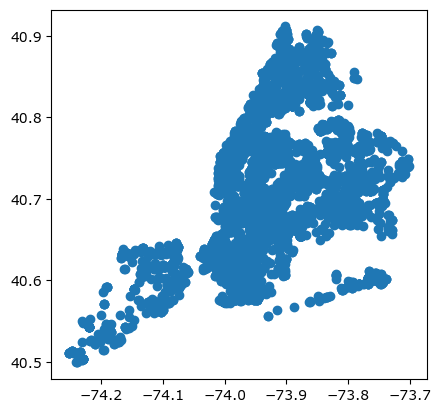

In [10]:
gdf_active_permits.plot()

In [11]:
total_permits = len(df_active_permits)
permits_by_type = df_active_permits['permit_type'].value_counts()
permits_by_borough = df_active_permits['borough'].value_counts()
permits_by_filing_status = df_active_permits['filing_status'].value_counts()
permits_by_year = df_active_permits['issuance_date'].dt.year.value_counts().sort_index()
summary_data = {
    'Metric': [
        'Total Number of Permits',
        'Number of Permits by Type',
        'Number of Permits by Borough',
        'Number of Permits by Filing Status',
        'Number of Permits by Year',
    ],
    'Value': [
        total_permits,
        permits_by_type.to_dict(),
        permits_by_borough.to_dict(),
        permits_by_filing_status.to_dict(),
        permits_by_year.to_dict(),
    ]
}

# Create summary table DataFrame
summary_table = pd.DataFrame(summary_data)

In [12]:
gdf_active_permits.columns.tolist()

['borough',
 'bin_#',
 'house_#',
 'street_name',
 'job_#',
 'job_doc._#',
 'job_type',
 'self_cert',
 'block',
 'lot',
 'community_board',
 'zip_code',
 'bldg_type',
 'residential',
 'special_district_1',
 'special_district_2',
 'work_type',
 'permit_status',
 'filing_status',
 'permit_type',
 'permit_sequence_#',
 'permit_subtype',
 'oil_gas',
 'site_fill',
 'filing_date',
 'issuance_date',
 'expiration_date',
 'job_start_date',
 "permittee's_first_name",
 "permittee's_last_name",
 "permittee's_business_name",
 "permittee's_phone_#",
 "permittee's_license_type",
 "permittee's_license_#",
 'act_as_superintendent',
 "permittee's_other_title",
 'hic_license',
 "site_safety_mgr's_first_name",
 "site_safety_mgr's_last_name",
 'site_safety_mgr_business_name',
 'superintendent_first_&_last_name',
 'superintendent_business_name',
 "owner's_business_type",
 'non-profit',
 "owner's_business_name",
 "owner's_first_name",
 "owner's_last_name",
 "owner's_house_#",
 "owner's_house_street_name",
 '

In [13]:
permit_type_mapping = {
    'AL': 'Alteration',
    'DM': 'Demolition',
    'EQ': 'Construction Equipment',
    'EW': 'Equipment Work',
    'FO': 'Foundation',
    'NB': 'New Building',
    'PL': 'Plumbing',
    'SG': 'Sign'
}

bldg_type_mapping = {
    1: 'Single, two, or three family build',
    2: 'Multiple dwellings'
}


gdf_active_permits['permit_type'] = gdf_active_permits['permit_type'].map(permit_type_mapping)
gdf_active_permits['bldg_type'] = gdf_active_permits['bldg_type'].map(bldg_type_mapping)

## Summary table on just the permit data with some key metrics

In [14]:
total_permits = len(gdf_active_permits)
permits_by_type = gdf_active_permits['permit_type'].value_counts().reset_index()
permits_by_type.columns = ['Permit Type', 'Value']

permits_by_borough = gdf_active_permits['borough'].value_counts().reset_index()
permits_by_borough.columns = ['Borough', 'Value']

permits_by_filing_status = gdf_active_permits['filing_status'].value_counts().reset_index()
permits_by_filing_status.columns = ['Filing Status', 'Value']

permits_by_bldg_type = gdf_active_permits['bldg_type'].value_counts().reset_index()
permits_by_bldg_type.columns = ['Building Type', 'Value']

permits_by_year = gdf_active_permits['issuance_date'].dt.year.value_counts().sort_index().reset_index()
permits_by_year.columns = ['Year', 'Value']

gdf_active_permits.job_start_date = pd.to_datetime(gdf_active_permits['job_start_date'])
gdf_active_permits['time_since_job_start'] = today - gdf_active_permits['job_start_date']
median_time_since_job_start = gdf_active_permits['time_since_job_start'].median()

owner_business_type_counts = gdf_active_permits["owner's_business_type"].value_counts().reset_index()
owner_business_type_counts.columns = ['Owner\'s Business Type', 'Count']

# Create some summary DataFrames
total_permits_df = pd.DataFrame({
    'Metric': ['Total Number of Permits'],
    'Value': [total_permits]
})

median_permits_df = pd.DataFrame({
    'Metric': ['Median number of days since Job Start Date'],
    'Value': [median_time_since_job_start]
})

summary_by_type = pd.DataFrame({
    'Metric': 'Number of Permits by Permit Type',
    'Category': permits_by_type['Permit Type'],
    'Value': permits_by_type['Value']
})

summary_by_borough = pd.DataFrame({
    'Metric': 'Number of Permits by Borough',
    'Category': permits_by_borough['Borough'],
    'Value': permits_by_borough['Value']
})

summary_by_filing_status = pd.DataFrame({
    'Metric': 'Number of Permits by Filing Status',
    'Category': permits_by_filing_status['Filing Status'],
    'Value': permits_by_filing_status['Value']
})

summary_by_bldg_type = pd.DataFrame({
    'Metric': 'Number of Permits by Buidling Type',
    'Category': permits_by_bldg_type['Building Type'],
    'Value': permits_by_bldg_type['Value']
})

summary_by_owner_business_type = pd.DataFrame({
    'Metric': 'Owner Businesss Type',
    'Category': owner_business_type_counts['Owner\'s Business Type'],
    'Value': owner_business_type_counts['Count']
})

summary_by_year = pd.DataFrame({
    'Metric': 'Number of Permits by Year',
    'Category': permits_by_year['Year'],
    'Value': permits_by_year['Value']
})

# Combine all summary DataFrames
combined_summary = pd.concat([
    total_permits_df,
    median_permits_df,
    summary_by_type,
    summary_by_borough,
    summary_by_filing_status,
    summary_by_bldg_type,
    summary_by_owner_business_type,
    summary_by_year
])
combined_summary = combined_summary[['Metric','Category','Value']]
combined_summary.to_excel('output/active_permit_summary_table.xlsx', index=False)

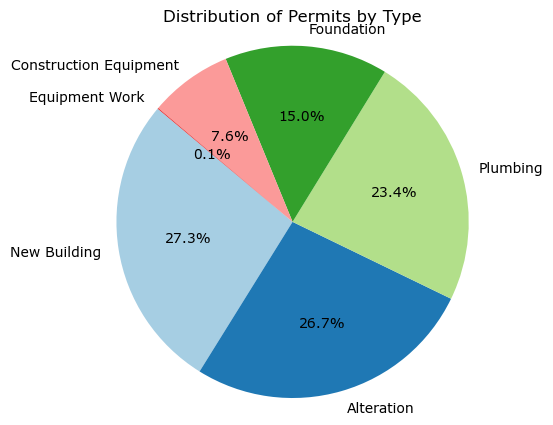

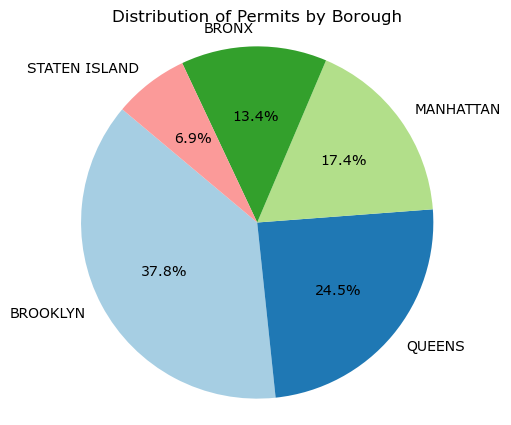

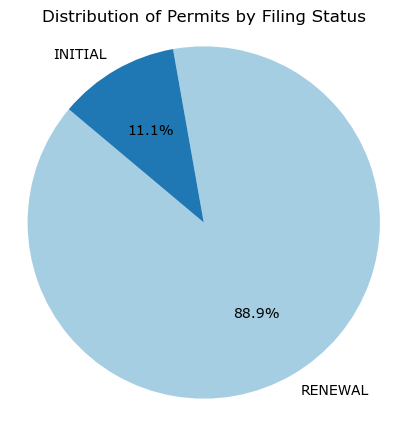

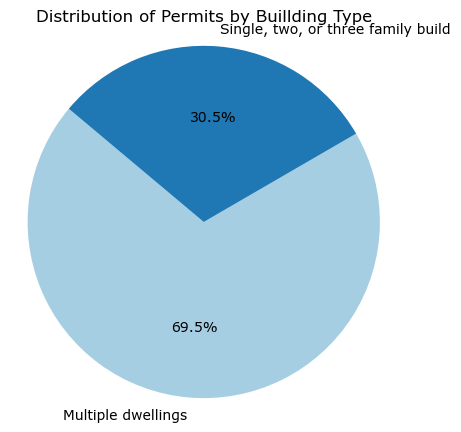

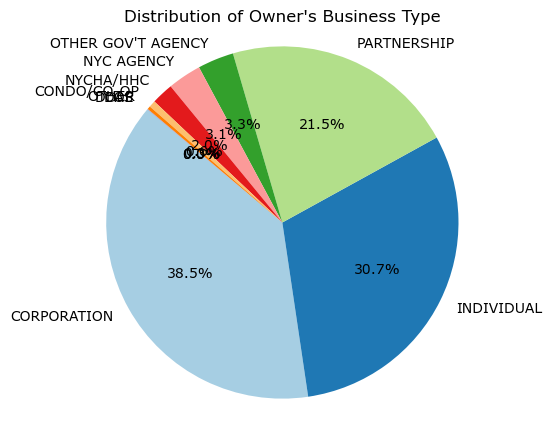

In [15]:
# Plot pie chart for Permits by Type
plt.figure(figsize=(5, 5))
plt.pie(permits_by_type['Value'], labels=permits_by_type['Permit Type'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(permits_by_type))))
plt.title('Distribution of Permits by Type')
plt.axis('equal')  
plt.show()

# Plot pie chart for Permits by Borough
plt.figure(figsize=(5, 5))
plt.pie(permits_by_borough['Value'], labels=permits_by_borough['Borough'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(permits_by_borough))))
plt.title('Distribution of Permits by Borough')
plt.axis('equal') 
plt.show()

# Plot pie chart for Permits by Filing Status
plt.figure(figsize=(5, 5))
plt.pie(permits_by_filing_status['Value'], labels=permits_by_filing_status['Filing Status'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(permits_by_filing_status))))
plt.title('Distribution of Permits by Filing Status')
plt.axis('equal') 
plt.show()

# Plot pie chart for Permits by Filing Status
plt.figure(figsize=(5, 5))
plt.pie(permits_by_bldg_type['Value'], labels=permits_by_bldg_type['Building Type'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(permits_by_filing_status))))
plt.title('Distribution of Permits by Buillding Type')
plt.axis('equal') 
plt.show()

# Plot pie chart for Owner's Business Type
plt.figure(figsize=(5, 5))
plt.pie(owner_business_type_counts['Count'], labels=owner_business_type_counts['Owner\'s Business Type'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(owner_business_type_counts))))
plt.title('Distribution of Owner\'s Business Type')
plt.axis('equal')  
plt.show()

## Quickly mapping some columns with values I find interesting

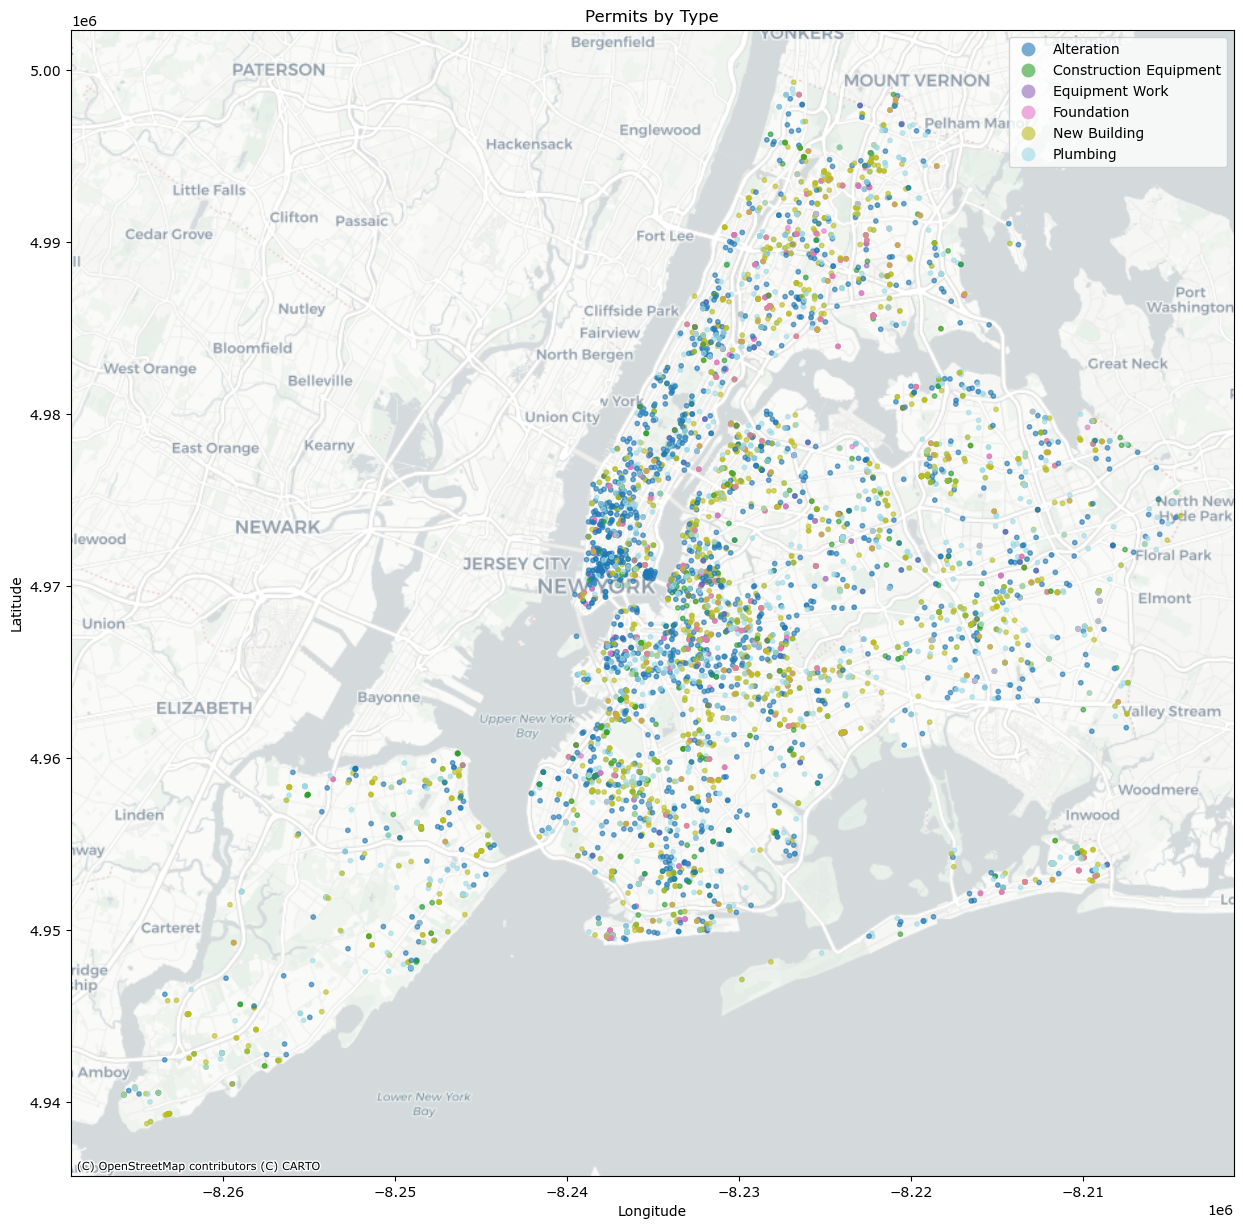

In [16]:
import contextily as ctx

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_active_permits.to_crs(3857).plot(column='permit_type', ax=ax, legend=True,
                       cmap='tab20', markersize=10, alpha=0.6) 

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title('Permits by Type')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

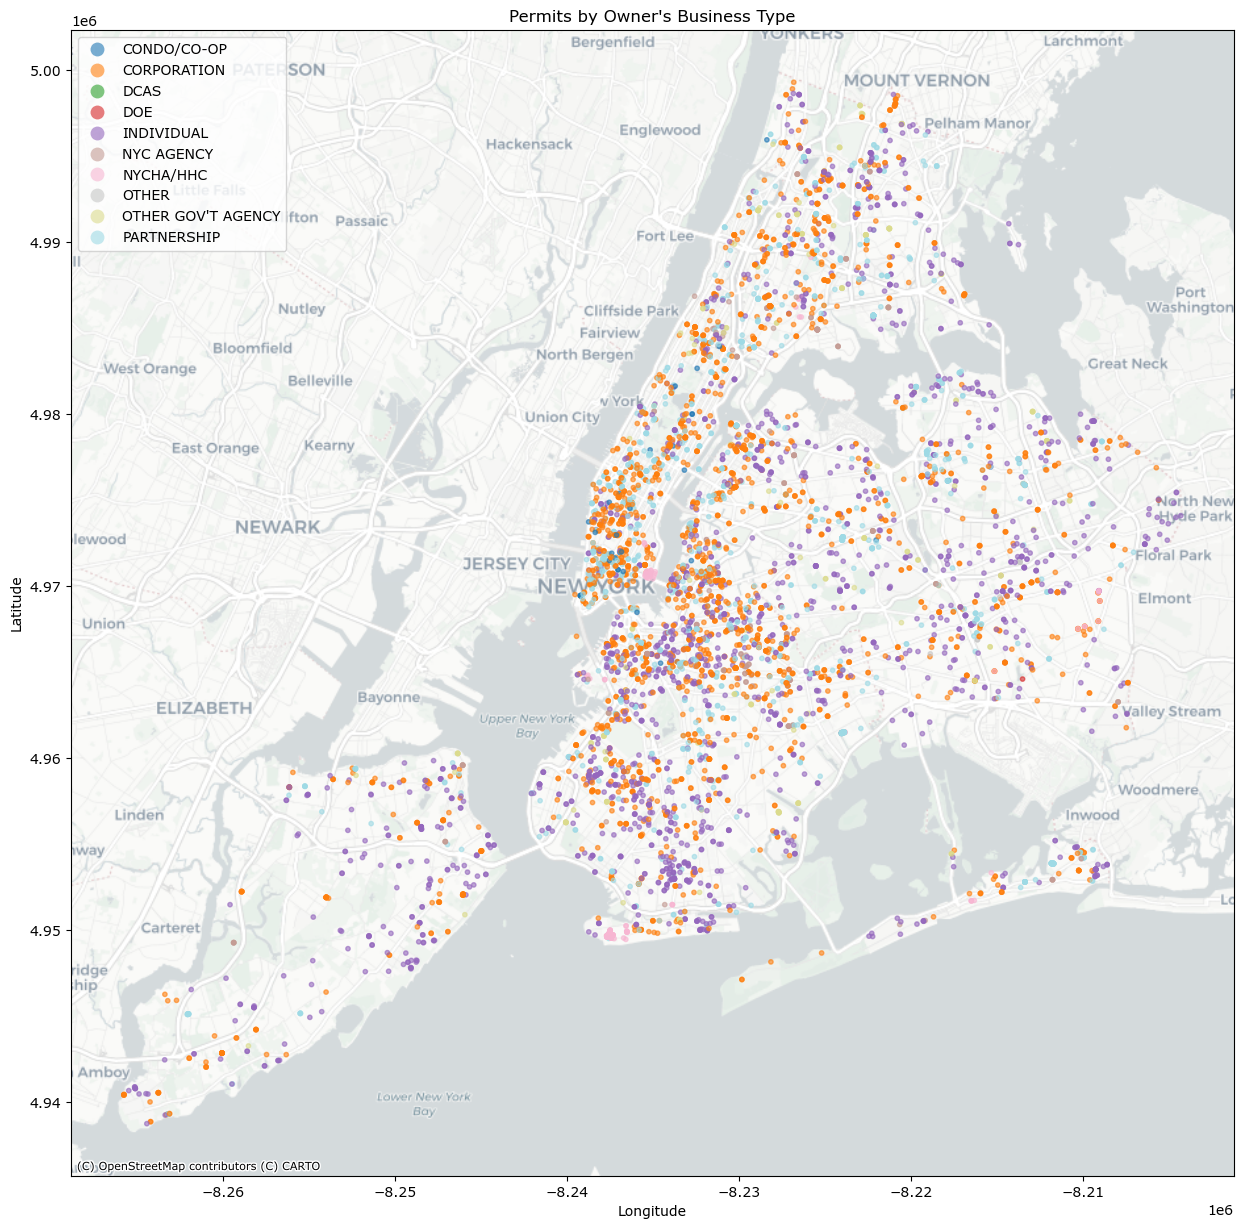

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_active_permits.to_crs(3857).plot(column="owner's_business_type", ax=ax, legend=True,
                       cmap='tab20',markersize=10, alpha=0.6) 

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Permits by Owner's Business Type")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## Quickly timeseries map using columns with values I find interesting

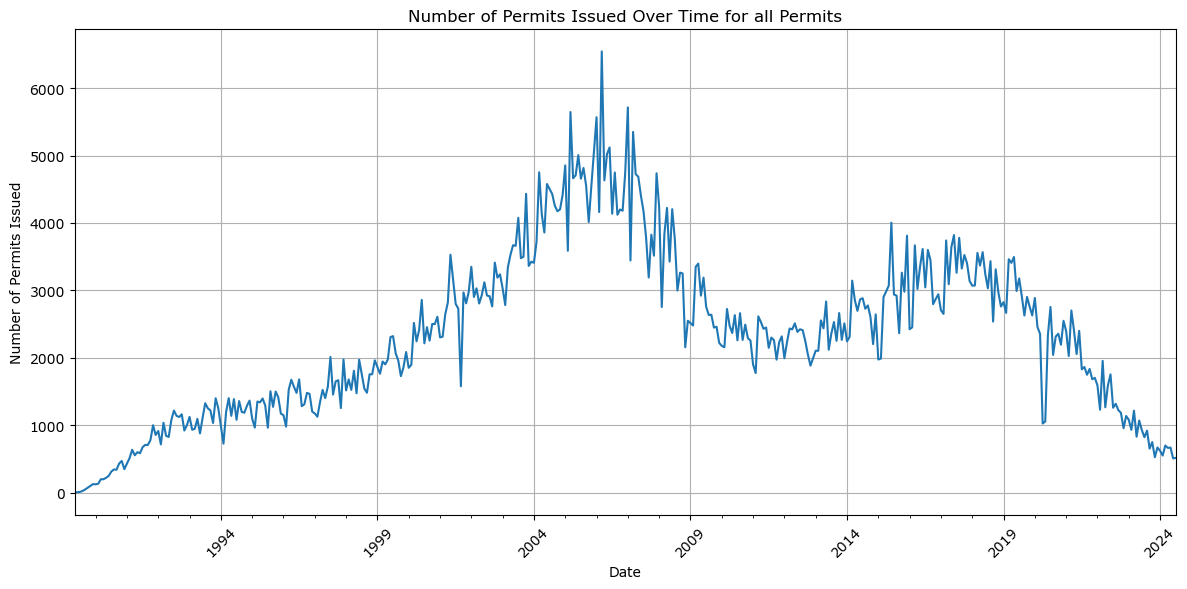

In [18]:
# Plot time series for all issuance_date
plt.figure(figsize=(12, 6))
df_permits['issuance_date'].groupby(df_permits['issuance_date'].dt.to_period("M")).count().plot()
plt.title('Number of Permits Issued Over Time for all Permits')
plt.xlabel('Date')
plt.ylabel('Number of Permits Issued')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

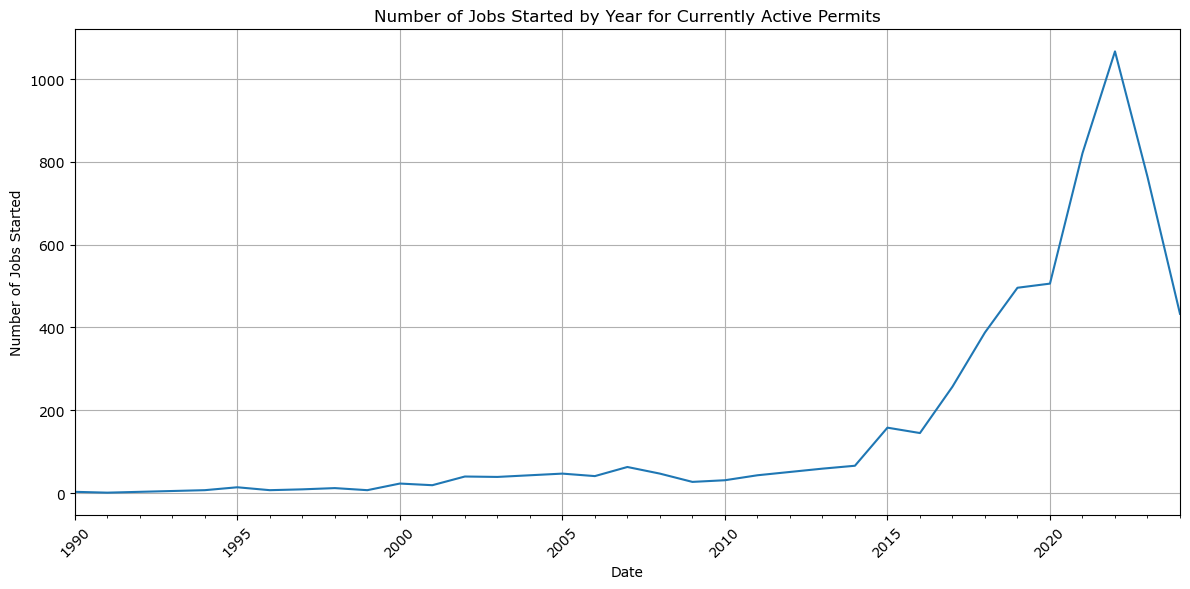

In [19]:
filtered_data = gdf_active_permits[gdf_active_permits['job_start_date'] <= today]
job_start_counts = filtered_data['job_start_date'].groupby(filtered_data['job_start_date'].dt.to_period("Y")).count()

# Plot time series for active permit job start dates
plt.figure(figsize=(12, 6))
job_start_counts.plot()
plt.title('Number of Jobs Started by Year for Currently Active Permits')
plt.xlabel('Date')
plt.ylabel('Number of Jobs Started')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Aggregating Spatially

I will be aggregating data at the NTA level, and combining it with some aggregated parcel land use data to hopefully uncover some interesting patterns. Using NTA boundaries will allow us to bring in demographic data from the census for future investigation. 

- Export your final data to excel and shapefile

Optionally, include some extra analysis or functionalities of your choice. A few ideas:
- Perform a statistical test on the data (e.g. linear regression, clustering) and characterize results
- Scale/normalize key metrics and create a composite indicator of development activity
- Identify existing parcel land uses and buildings to understand how the build landscape is changing

In [23]:
CT2020_geojson_URL = 'https://data.cityofnewyork.us/resource/63ge-mke6.geojson'
limit = '10000'
gdf_CT2020 = gpd.read_file(f'{CT2020_geojson_URL}?$limit={limit}')

In [24]:
NTA2020_geojson_URL = 'https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson'
limit = '10000'
gdf_NTA2020 = gpd.read_file(f'{NTA2020_geojson_URL}?$limit={limit}')

In [25]:
pluto_json_url = "https://data.cityofnewyork.us/resource/64uk-42ks.json"
limit = '1000000'
df_pluto = pd.read_json(f'{pluto_json_url}?$limit={limit}')

In [26]:
df_pluto = df_pluto.dropna(subset=['bct2020']) 
df_pluto['bct2020'] = df_pluto['bct2020'].apply(lambda x: str(int(x)))
merged_gdf = gdf_CT2020.merge(df_pluto, left_on='boroct2020', right_on='bct2020')

In [27]:
# Find primary landuse by area within 2020NTA and also summing area usage
grouped = merged_gdf.groupby(['nta2020', 'landuse'])['bldgarea'].sum().reset_index()
primary_landuse = grouped.loc[grouped.groupby('nta2020')['bldgarea'].idxmax()].reset_index(drop=True)
primary_landuse = primary_landuse.rename(columns={'bldgarea': 'primarylanduse_bldgarea'})
area_columns = ['assessland','assesstot','bldgarea','comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea']
summed_areas = merged_gdf.groupby('nta2020')[area_columns].sum().reset_index()

result = pd.merge(primary_landuse, summed_areas, on='nta2020')

In [28]:
# Create NTA geometries with summarized primary landuse data 
gdf_pluto_nta = gdf_NTA2020[['ntaname', 'nta2020', 'shape_area','geometry']].merge(result, on='nta2020')

In [29]:
gdf_active_permits = gdf_active_permits.to_crs(gdf_pluto_nta.crs)
gdf_active_permits_nta = gpd.sjoin(gdf_pluto_nta, gdf_active_permits, how='left', op='contains')
no_permits = gdf_active_permits_nta[gdf_active_permits_nta['index_right'].isnull()]
percentage_no_permits = (len(no_permits) / len(gdf_pluto_nta)) * 100
print(f"{percentage_no_permits}% of NTAs has no active permits")

19.230769230769234% of NTAs has no active permits


In [91]:
gdf_active_permits = gdf_active_permits.to_crs(gdf_pluto_nta.crs)
gdf_joined = gpd.sjoin(gdf_active_permits, gdf_pluto_nta, how='left', op='within')
nta_permit_counts = gdf_joined.groupby('nta2020').size().reset_index(name='permit_count')
nta_business_type_counts = gdf_joined.groupby(['nta2020', "owner's_business_type"]).size().reset_index(name='business_type_count')
nta_permit_type_counts = gdf_joined.groupby(['nta2020', 'permit_type']).size().reset_index(name='permit_type_count')
pivot_permit_type_counts = nta_permit_type_counts.pivot_table(
    index='nta2020',
    columns="permit_type",
    values='permit_type_count',
    fill_value=0
)

pivot_business_type_counts = nta_business_type_counts.pivot_table(
    index='nta2020',
    columns="owner's_business_type",
    values='business_type_count',
    fill_value=0
)

In [101]:
# Some small useful data summaries
nta_permit_counts.to_csv('output/nta_permit_counts.csv', index=False)
nta_business_type_counts.to_csv('output/nta_permit_business_type_counts.csv', index=False)
nta_permit_type_counts.to_csv('output/nta_permit_type_counts.csv', index=False)

<Figure size 1200x800 with 0 Axes>

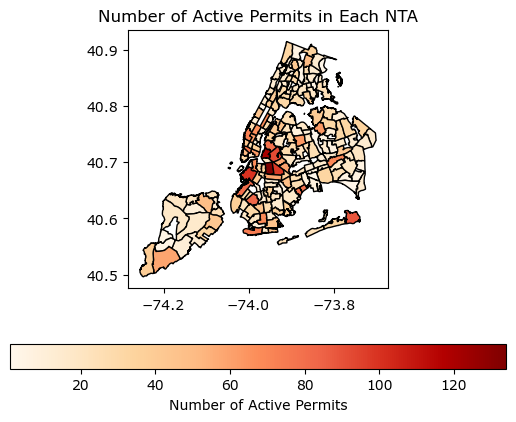

In [65]:
# Merge permit counts with the NTA GeoDataFrame
gdf_nta_permit_counts = gdf_pluto_nta.merge(nta_permit_counts, left_on='nta2020', right_on='nta2020')

plt.figure(figsize=(12, 8))
ax = gdf_nta_permit_counts.plot(column='permit_count', cmap='OrRd', legend=True,
                                legend_kwds={'label': "Number of Active Permits",
                                             'orientation': "horizontal"},
                                edgecolor='black')
plt.title('Number of Active Permits in Each NTA')
plt.show()

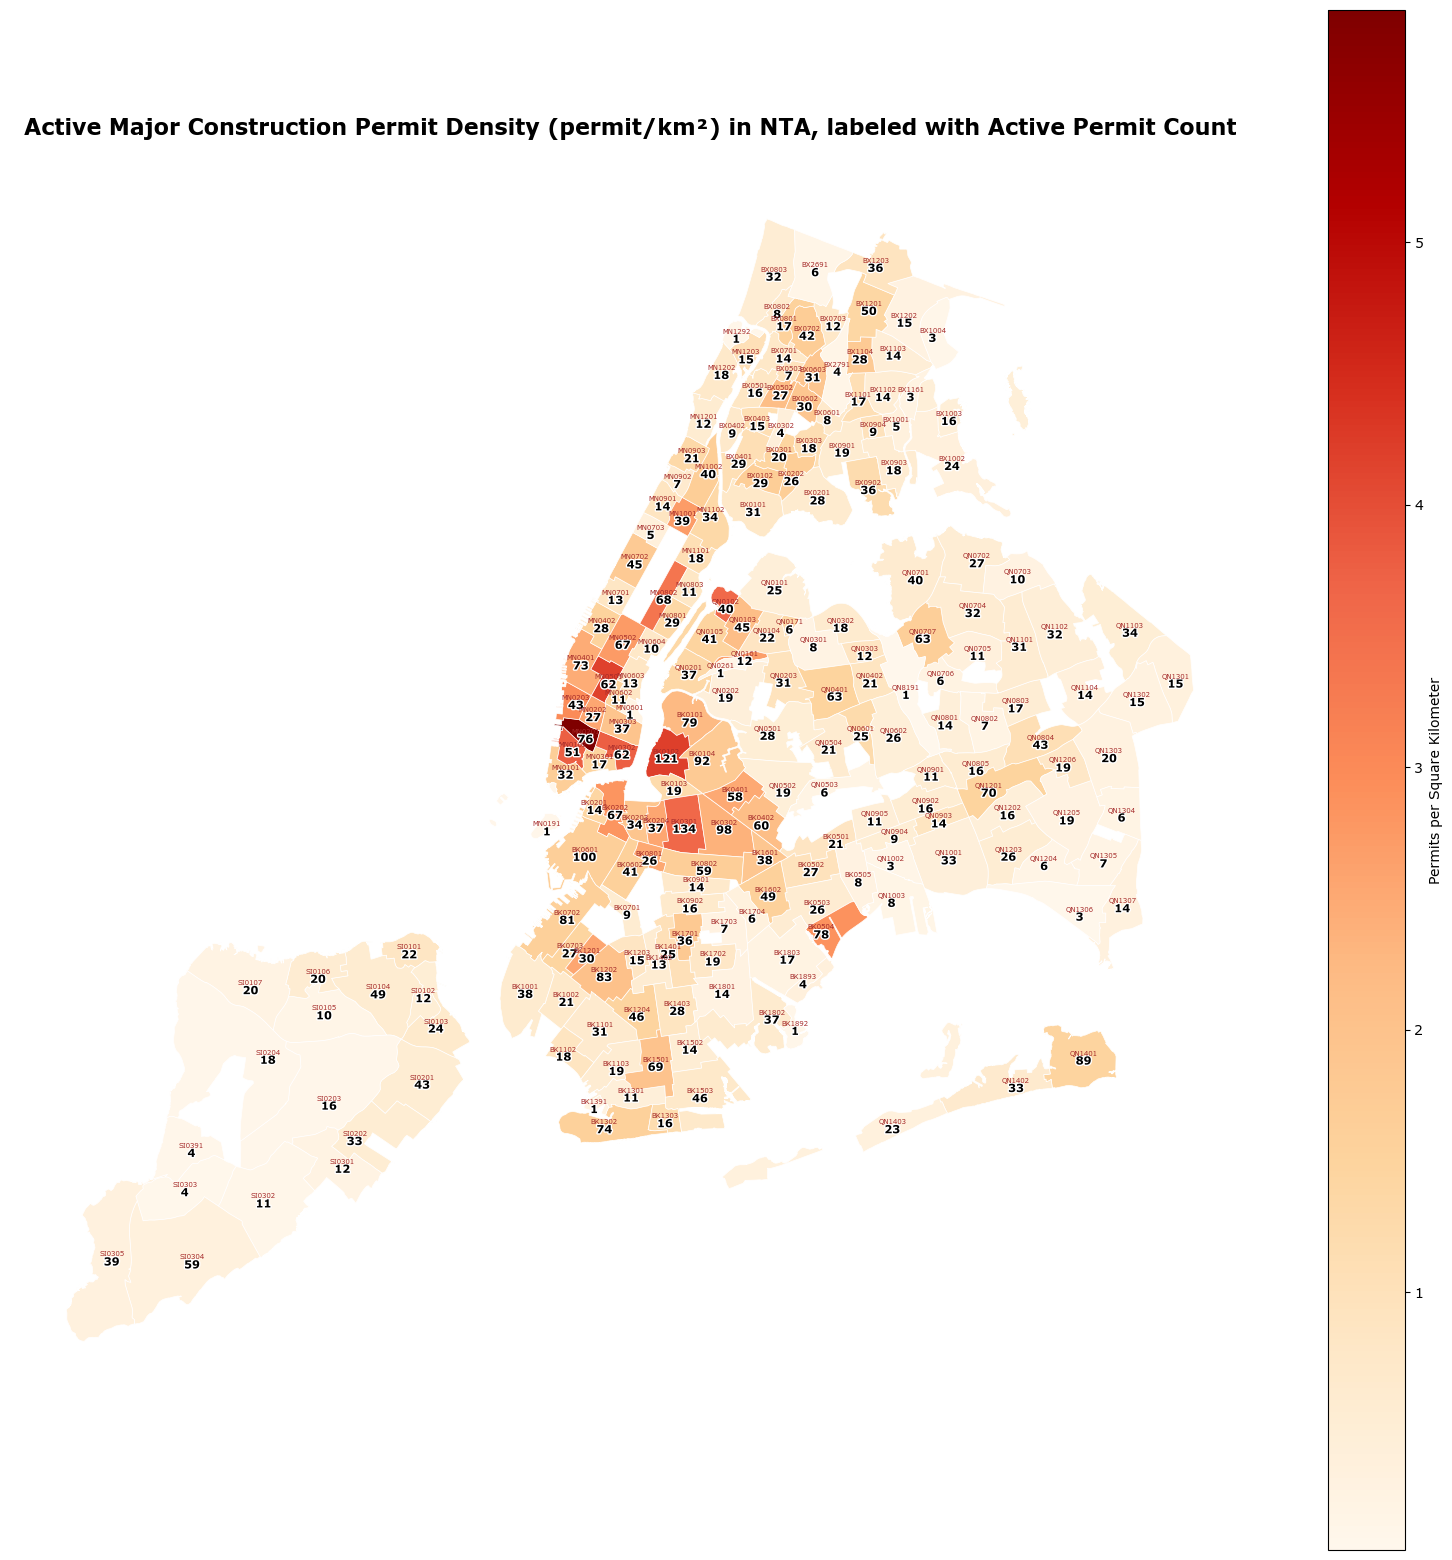

In [66]:
# Merge permit counts with the NTA GeoDataFrame
gdf_nta_permit_counts['shape_area'] = pd.to_numeric(gdf_nta_permit_counts['shape_area'], errors='coerce')
gdf_nta_permit_counts['shape_area_km2'] = gdf_nta_permit_counts['shape_area'] / 1_000_000
gdf_nta_permit_counts['permit_density'] = gdf_nta_permit_counts['permit_count'] / gdf_nta_permit_counts['shape_area_km2']


fig, ax = plt.subplots(figsize=(20, 20))
gdf_nta_permit_counts.plot(column='permit_density', cmap='OrRd', legend=True,
                           legend_kwds={'label': "Permits per Square Kilometer",
                                        'orientation': "vertical"},
                           edgecolor='white', linewidth=0.5, ax=ax)

plt.title('Active Major Construction Permit Density (permit/km²) in NTA, labeled with Active Permit Count', fontsize=16, fontweight='bold',pad=20)
ax.set_axis_off()
white_outline = withStroke(linewidth=2, foreground='white')

# Annotate each NTA with permit count and nta2020
for idx, row in gdf_nta_permit_counts.iterrows():
    # Extract the centroid of each geometry
    xy = row.geometry.representative_point().coords[0]
    ax.annotate(f'{row["permit_count"]}', xy=xy,
                va='top',
                fontsize=8, color='black',
                fontweight="bold",
                ha='center',path_effects=[white_outline])
    
for idx, row in gdf_nta_permit_counts.iterrows():
    xy = row.geometry.representative_point().coords[0]
    ax.annotate(f'{row["nta2020"]}', xy=xy,
                 va='bottom',
                fontsize=5, color='brown',
                ha='center')
plt.savefig('export/active_permit_density_map.svg', format='svg', bbox_inches='tight', pad_inches=0.1)
plt.savefig('export/active_permit_density_map.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [67]:
gdf_pluto_nta['comarea%'] = gdf_pluto_nta['comarea']/gdf_pluto_nta['bldgarea']
gdf_pluto_nta['resarea%'] = gdf_pluto_nta['resarea']/gdf_pluto_nta['bldgarea']
gdf_nta_business_area = gdf_pluto_nta[['assessland','assesstot','comarea%','resarea%','nta2020']].merge(nta_business_type_counts, left_on='nta2020', right_on='nta2020')
pivot_business_type_counts = gdf_nta_business_area.pivot_table(
    index='nta2020',
    columns="owner's_business_type",
    values='business_type_count',
    fill_value=0
)
combined_data = gdf_pluto_nta[['assessland','assesstot','comarea%','resarea%','nta2020']].merge(pivot_business_type_counts, left_on='nta2020', right_index=True)
combined_data.rename(columns={'comarea%': 'Percentage Commercial Area', 'resarea%': 'Percentage Residential Area','assesstot':'Assessed Total Value', 'assessland':'Assessed Land Value',
                             'CONDO/CO-OP': 'Condo/Co-op',
                              'CORPORATION': 'Corporation',
                              'DCAS': 'DCAS',
                              'DOE': 'DOE',
                              'INDIVIDUAL': 'Individual',
                              'NYC AGENCY': 'NYC Agency',
                              'NYCHA/HHC': 'NYCHA/HHC',
                              'OTHER': 'Other',
                              "OTHER GOV'T AGENCY": 'Other Government Agency',
                              'PARTNERSHIP': 'Partnership'}, inplace=True)

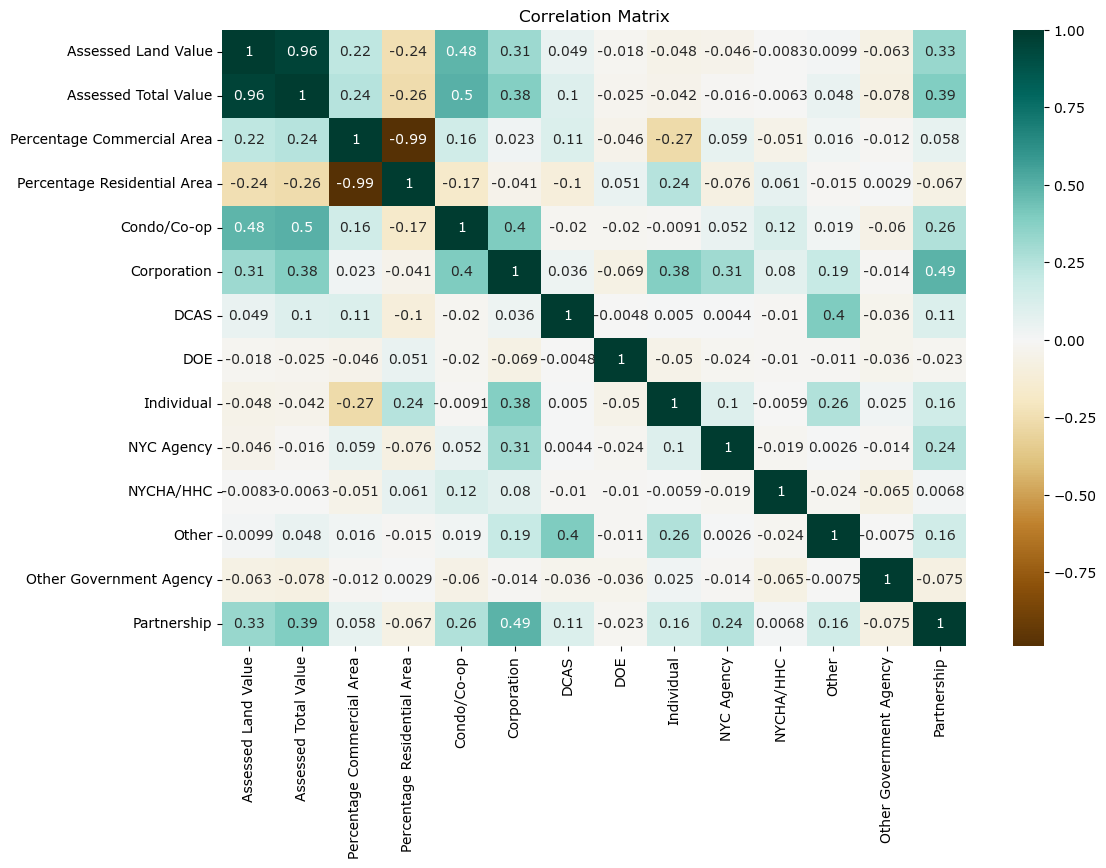

In [68]:
correlation_matrix = combined_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', center=0)
plt.title('Correlation Matrix')
plt.show()

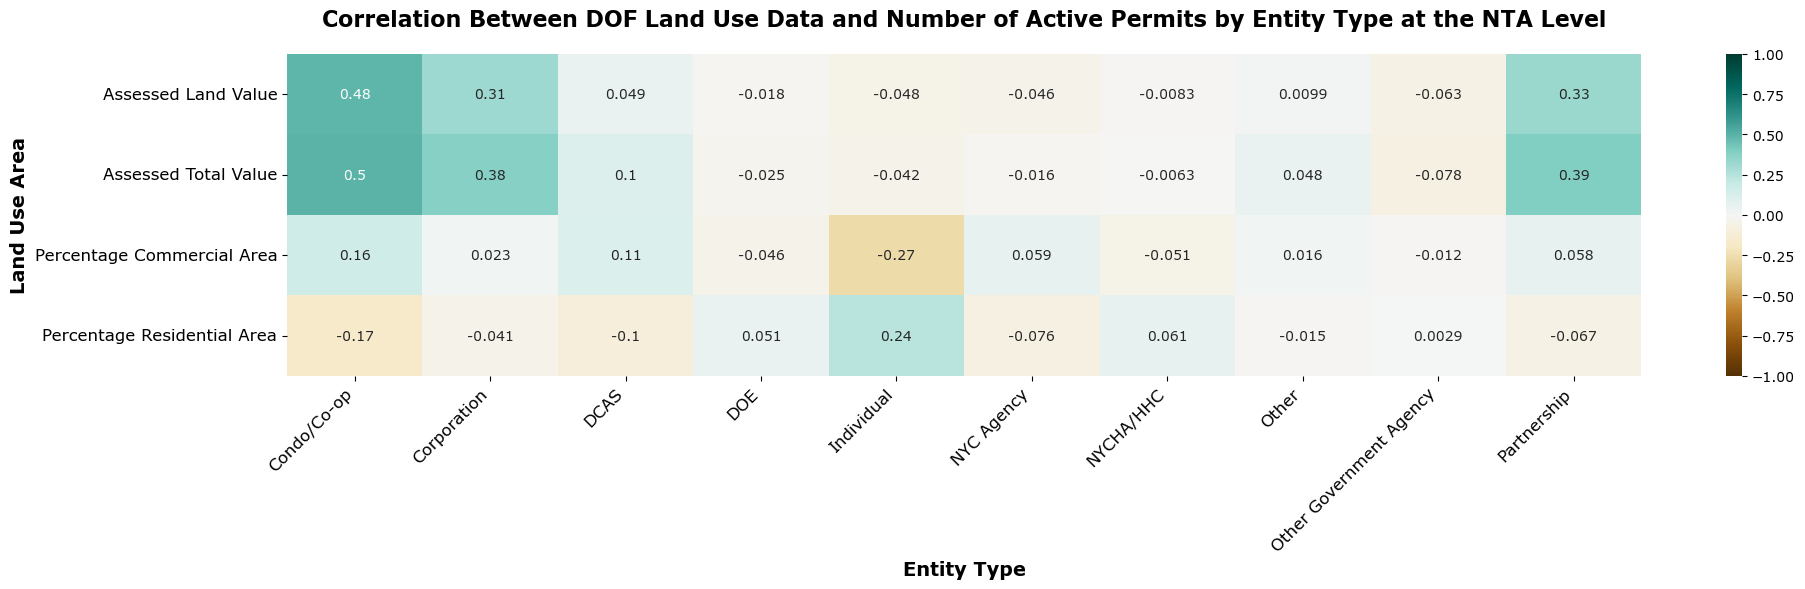

In [69]:
# Correlation to understand what types of entities are building in what types of areas
subset_correlation_matrix = correlation_matrix.iloc[:4, 4:]
plt.figure(figsize=(20, 6))
sns.heatmap(subset_correlation_matrix, annot=True, cmap='BrBG', center=0, vmin=-1, vmax=1)
plt.title("Correlation Between DOF Land Use Data and Number of Active Permits by Entity Type at the NTA Level", 
          fontsize=16, fontweight='bold',pad=20)
plt.xlabel("Entity Type", fontsize=14, fontweight='bold')
plt.ylabel("Land Use Area", fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()


plt.savefig('export/correlation_matrix.svg', format='svg', bbox_inches='tight', pad_inches=0.1)
plt.savefig('export/correlation_matrix.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

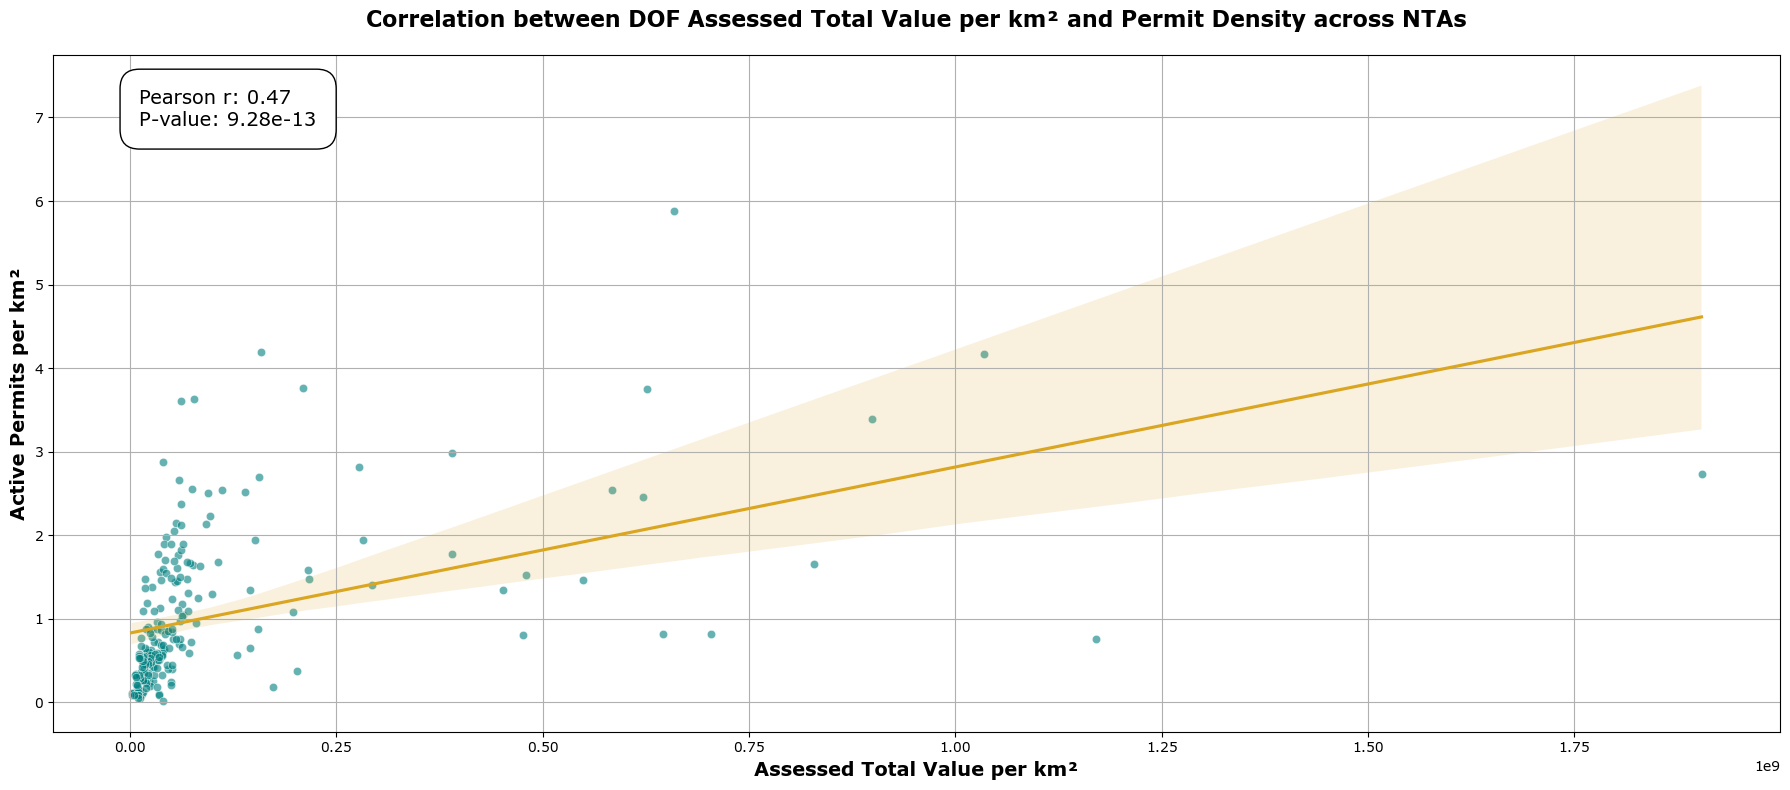

In [70]:
# Correlation to understand relationship between assessment value and the number of active permits in the NTA
gdf_nta_permit_counts['total_value_per_km2'] = gdf_nta_permit_counts['assesstot'] / gdf_nta_permit_counts['shape_area_km2']

correlation, p_value = pearsonr(gdf_nta_permit_counts['total_value_per_km2'], gdf_nta_permit_counts['permit_density'])

# Plot the scatter plot with a regression line
plt.figure(figsize=(18, 8))
sns.regplot(
    x='total_value_per_km2', 
    y='permit_density', 
    data=gdf_nta_permit_counts, 
    scatter_kws={"color": "teal", 'alpha':0.6, 'edgecolors':'w', 'linewidth':0.5},
    line_kws={'color': 'goldenrod'}
)
plt.title('Correlation between DOF Assessed Total Value per km² and Permit Density across NTAs', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Assessed Total Value per km²', fontsize=14, fontweight='bold')
plt.ylabel('Active Permits per km²', fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()

# Display the correlation coefficient in the plot
plt.text(
    0.05, 0.95, f'Pearson r: {correlation:.2f}\nP-value: {p_value:.2e}', 
    transform=plt.gca().transAxes, 
    fontsize=14, verticalalignment='top', 
    bbox=dict(boxstyle='round,pad=1', edgecolor='black', facecolor='white')
)

plt.savefig('export/correlation_assesstot_permitdensity.svg', format='svg', bbox_inches='tight', pad_inches=0.1)
plt.savefig('export/correlation_assesstot_permitdensity.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [100]:
gdf_nta_permit_counts_all = gdf_nta_permit_counts.merge(combined_data[['nta2020','Condo/Co-op','Corporation','DCAS','DOE','Individual','NYC Agency','NYCHA/HHC','Other','Other Government Agency','Partnership']], on='nta2020')
gdf_nta_permit_counts_all = gdf_nta_permit_counts_all.merge(pivot_permit_type_counts, left_on='nta2020', right_index= True)

new_column_order = ['ntaname',
                     'nta2020',
                     'landuse',
                     'primarylanduse_bldgarea',
                     'assessland',
                     'assesstot',
                     'total_value_per_km2',
                     'bldgarea',
                     'comarea',
                     'resarea',
                     'officearea',
                     'retailarea',
                     'garagearea',
                     'strgearea',
                     'factryarea',
                     'otherarea',
                     'permit_count',
                     'permit_density',
                     'Condo/Co-op','Corporation','DCAS','DOE','Individual','NYC Agency','NYCHA/HHC','Other','Other Government Agency','Partnership',
                     'Alteration','Construction Equipment','Equipment Work','Foundation','New Building','Plumbing',
                     'shape_area',
                     'shape_area_km2',
                     'geometry'
                   ]

gdf_nta_permit_counts_all = gdf_nta_permit_counts_all[new_column_order]

# Save as CSV
csv_file_path = 'output/FINAL_nta_pluto_permit.csv'
gdf_nta_permit_counts_all.to_csv(csv_file_path, index=False)

# Save as Excel
excel_file_path = 'output/FINAL_nta_pluto_permit.xlsx'
gdf_nta_permit_counts_all.to_excel(excel_file_path, index=False)

# Save as Shapefile
shapefile_dir = 'output/FINAL_nta_pluto_permit_shapefile'
gdf_nta_permit_counts_all.to_file(shapefile_dir, driver='ESRI Shapefile')